# Hands-on Case Study 2: Build and Solve a Mathematical Optimization Model Using Gurobi with Solar Power Forecast Data

## Solution Approach

After preparing the **forecasting component** (see [ML_solar_energy_forecast](ML_solar_energy_forecast.ipynb) notebook) for the solar availability, now we will build the **optimization component** to determine the battery schedule as well as the amount of electricity purchased from the grid.

The forecasting component was completed in the [ML_solar_energy_forecast](ML_solar_energy_forecast.ipynb) notebook in this folder. 
We'll use a given forecast from that model ([ml_pred_solar_values.csv](ml_pred_solar_values.csv) file), as well as the demand of building and each of the courses and the expected price of grid electricity ([ml_building_demand.csv](ml_building_demand.csv), [ml_schedule_demand.csv](ml_schedule_demand.csv), and [ml_expected_price.csv](ml_expected_price.csv) files) to formulate and solve a **Mixed Integer Linear Programming (MILP)** problem to find the optimal solution to the problem for each of the above objectives using gurobipy.

## Optimal Battery Schedule (Build and Solve the MIP)
Now that we have a forecast of solar generation, we will create an optimization model that will schedule the charging and discharging of two batteries to help meet the building and course energy demand.

### 1. Packages Install and Loading 
We begin our solution approach by installing the necessary packages which will be needed:

In [24]:
import subprocess
import sys
# Configure logging to only display CRITICAL level messages or higher
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
# Install and import the required packages
def install_and_import(package, version=None):
    try:
        __import__(package)
    except ImportError:
        if version:
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package}=={version}"])
        else:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        __import__(package)

install_and_import("gurobipy", "11.0.3") # Gurobi's optimization package for solving the optimization problem

Then we import the required packages

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

### 2. Inputs

#### 2.1. Sets and Indices

There are two batteries available that can be charged and discharged. Hence, we need an index to describe the existence and operation of each of the batteries. Finally, given that we would like to create the battery schedule in 30-minute intervals for the next month, we need to define an index for the time periods too. 

**2.1.1. Sets**

- $B = \{\texttt{Battery0, Battery1}\} \quad\quad$ `batteries`
- $T = \{0,1,...,179\}$ for the first Monday through Saturday of October, 2020 from 5am to 8pm, 30 periods per day $\quad$ `time_periods`

**2.1.2. Indices**

- $b$: denotes the battery (0 or 1)
- $t$: denotes the time periods (from 0 to 179) 

### 2.2. Input Parameters

Each of the batteries has a fixed capacity of how much energy it can store, as well as a maximum amount of energy that can be stored or discharged for each 30-minute period.

**2.2.1. Capacities, Energy Loss, Solar Power Generation**

- $c_{b}$: capacity of battery $b \in B \quad\quad$ `capacity[b]`
- $p_{b}$: loss of energy (as a percentage) during transfer into battery $b\in B \quad\quad$ `p_loss[b]`
- $q_{b}$: quantity of initial energy in battery $b \in B \quad\quad$ `initial[b]`

**2.2.2. Energy Demand and Power Generation**

The energy demand at each time period originates from two sources: the building and the scheduled classes, while the power generation comes from solar panels. The total energy demand and power generation data are preprocessed and ordered by time periods from external files.

- $solar_{t}$: solar power generation of the panel for time period $t \in T \quad\quad$ `solar_values[t]`
- $d_{t}$: total building and class energy demand for time period $t\in T \quad\quad$ `total_deamnd[t]`

**2.2.3. Capacity of Charge/Discharge per Period**

Set the max amount $maxcd$ that each battery can charge or discharge in a single period to be 20 kW.$\quad\quad$ `max_cd`


In [26]:
# Define the batteries in the optimization problem
batteries = ["Battery0", "Battery1"]

# Read the solar power forecasting values from the CSV file
solar_values_read = pd.read_csv('ml_pred_solar_values.csv')

# Define the time periods based on the number of solar forecast values
time_periods = range(len(solar_values_read))

# Define the capacity for each battery in kW
capacity = {"Battery0": 60, "Battery1": 80}

# Define the energy loss proportion during energy transfer from solar panels to each battery
p_loss = {"Battery0": 0.95, "Battery1": 0.9}

# Define the initial energy in each battery in kW
initial = {"Battery0": 0, "Battery1": 0}

# Round the solar power forecast values to 3 decimal places
solar_values = round(solar_values_read.yhat, 3)

# Reset the index of the solar power forecasting values
solar_values.reset_index(drop=True, inplace=True)

# Read the schedule demand values from the CSV file
schedule = pd.read_csv('ml_schedule_demand.csv')

# Read the average building demand values from the CSV file
avg_building = pd.read_csv('ml_building_demand.csv')

# Calculate the total demand by summing the schedule demand and building demand
total_demand = schedule.sched_demand + avg_building.build_demand

# Print the total solar generation and total demand values
print(f"Total solar generation: {round(solar_values.sum(), 1)}")
print(f"Total demand: {round(total_demand.sum(), 1)}")

# Set the max amount that each battery can charge or discharge in a single period to be 20 kW.
max_cd = 20

Total solar generation: 4922.5
Total demand: 5250.6


### 3. Model Building (Decision Variables, Constraints, and Objective Function)
The line `m = gp.Model()` defines a new optimization model using Gurobi's Python interface (`gp`). This initializes an empty model object `m`, which will later be populated with decision variables, constraints, and the objective function as the problem formulation progresses. Essentially, it sets up the foundation where all the components of the optimization problem will be added and solved.

In [27]:
m = gp.Model() #this defines the model that we'll add to as we finish the formulation

#### 3.1. Decision Variables

The decisions for this optimization problem involve:
- Determining whether each battery should be charged or discharged during a specific time period.
- Deciding the amount of energy to charge or discharge from each battery.
- Tracking the current state of charge (SOC) of each battery at each time period.
- Calculating the amount of energy to be purchased from the grid to meet the total demand when renewable energy sources are insufficient.

Let $f^{in}_{b,t}$ be the amount each battery $b$ can **charge** at time period,  $t$, $\forall b\in B, t\in T$. $\quad$ `flow_in[b,t]`

Let $f^{out}_{b,t}$ be the amount each battery $b$ will **discharge** at time period,  $t$, $\forall b\in B, t\in T$.$\quad\quad$ `flow_out[b,t]`

In [28]:

flow_in = m.addVars(batteries, time_periods, name="flow_in") 
flow_out = m.addVars(batteries, time_periods, name="flow_out")

Next, there is the amount of energy that is purchased from the grid for each time period. We will assume this is a non-negative number and that we cannot "sell back" to the grid (although this is an interesting problem as well!)

$grid_{t}$ : This variable indicates the amount of energy purchased from the grid at time period, $t$, $\forall t \in T.\quad\quad$ `grid[t]`

In [29]:
grid = m.addVars(time_periods, name="grid")

The next two sets of decision variables will take on a slightly different role. First, we need to monitor the amount of energy stored in each battery (i.e., its state) at every time period. Additionally, we must track the utilization of solar energy, whether it is used for charging the batteries or directly supplying energy. 

$s_{b,t}$ is the current amount of energy in battery $b$ at the end of time period $t, \forall b\in B, t\in T$. $\quad\quad$ `state[b,t]`

$gen_{t}$ is the amount of available solar energy that is used in period $t$, $\forall t \in T$. $\quad\quad$ `gen[t]`


In [30]:
state = m.addVars(batteries, time_periods, name="state") 
gen = m.addVars(time_periods, name="gen")

The last decision variables to add will take care of a tricky instance that can arise in a problem like this -- a battery cannot simultaneously charge and discharge. Thus, we need to make sure each battery, at each time period, will be doing one of three things: 1. **charge**, 2. **discharge**, or 3. **neither**. 

To model this we introduce a binary variable for each time period, $z_{b,t}, \forall b \in B, t \in T$, which we'll call $\quad\quad$ `zwitch_[b,t]` 

In [31]:
zwitch = m.addVars(batteries, time_periods, vtype=GRB.BINARY, name="zwitch")

#### 3.2. Objective Function

The objective is to minimize the total amount of energy purchased from the grid over all time periods.
$$
\begin{align*} 
{\rm minimize} \quad \sum_{t} grid_{t}
\end{align*}
$$

In [32]:
m.setObjective(gp.quicksum(grid[t] for t in time_periods), GRB.MINIMIZE)

#### 3.3. Constraints

**3.3.1. Energy Demand Satisfaction Constraints**

At each time period, the total energy demand must be met. This demand can be satisfied through three sources:

1) **Grid Energy** – Purchasing energy from the grid.
2) **Solar Panel Energy** – Utilizing energy generated by the solar panels.
3) **Battery Discharge** – Drawing energy from the stored capacity of the batteries.

Additionally, charging the batteries during a time period must also be accounted for, as it reduces the net available energy during that period but ensures supply for future periods.

$$
\begin{align*} 
\sum_b(f^{out}_{b,t}-p_bf^{in}_{b,t}) + gen_t + grid_t = d_t \quad \forall t \in T
\end{align*}
$$

*Note:* Subtracting $\sum_b p_bf^{in}_{b,t}$ accounts for energy used to charge the batteries, as it reduces the net energy available for demand.

In [33]:
m.addConstrs((gp.quicksum(flow_out[b,t] - p_loss[b]*flow_in[b,t] for b in batteries) + gen[t] + grid[t] == total_demand[t] 
                  for t in time_periods), name="power_balance");

**3.3.2. Battery State Transition Constraints**

The state of each battery at a given time period depends on its state in the previous period, as well as the decisions to charge or discharge it during that period. The following equations define how a battery’s state evolves over time.

_Initial State Constraint_: The state of a battery at the end of the first period is determined by its initial energy, combined with the first period's charge and discharge decisions:
$$
\begin{align*} 
s_{b,0} = q_b + p_bf^{in}_{b,0} - f^{out}_{b,0}, \forall b \in B
\end{align*}
$$

_State Transition Constraint_: For all subsequent time periods (i.e. $t\geq 1$), the battery's state is updated based on its previous state, along with charge and discharge decisions during the current period:
$$
\begin{align*} 
s_{b,t} = s_{b,t-1} + p_bf^{in}_{b,t} - f^{out}_{b,t}, \forall b\in  B, t \geq 1
\end{align*}
$$

The respective constraints can be written as below.

In [34]:
m.addConstrs((state[b,0] == initial[b] + p_loss[b]*flow_in[b,0] - flow_out[b,0] for b in batteries), name="initial_state")
m.addConstrs((state[b,t] == state[b,t-1] + p_loss[b]*flow_in[b,t] - flow_out[b,t] for b in batteries for t in time_periods if t >= 1), name="subsequent_states");

**3.3.3. Solar Energy Allocation Constraint**

The availability of solar energy can be used in three places:
1. Charging `Battery0`
2. Charging `Battery1`
3. Directly meeting the energy demand

To ensure that the total solar energy used does not exceed the amount available, the following constraint is imposed:
$$
\begin{align*}
\sum_{b\in B} f^{in}_{b,t} + gen_t \le solar_t, \quad \forall t \in T
\end{align*}
$$

In [35]:
m.addConstrs((flow_in['Battery0',t] + flow_in['Battery1',t] + gen[t] <= solar_values[t] for t in time_periods), name = "solar_avail");

**3.3.4. Modeling Battery Charging and Discharging Logic Constraints (Using Binary Variables)**

Using binary variables to model alternatives like what we have here ($z_{b,t}$) is arguably the most difficult part of mathematical optimization modeling. It comes down to be able to represent a complex system using zeros, ones, and inequalities. To get the logic correct takes time and there is a lot of iteration at point to make sure it's done correctly. In short, do not worry if you find this part difficult. 

Let's formulate the constraints and then dive into why they work ($maxcd$ is set to 20Kw). 

$$
\begin{align*} 
f^{in}_{b,t} &\leq maxcd \times z_{b,t} &\forall b \in B, t \in T \\
f^{out}_{b,t} &\leq maxcd \times(1-z_{b,t}) &\forall b \in B, t \in T
\end{align*}
$$

To illustrate how this works let's consider an example -- suppose for one of batteries $f^{in}_{b,t} = 10 $ in a time period. For the first inequality to hold it is *necessary* that $z_{b,t} = 1$, otherwise it is $0$ and $20 \times 0 = 0$, which can't happen if $f^{in}_{b,t} = 10$. Then for the same time period, if $z_{b,t} = 1$, then  $1-z_{b,t} = 0$. This forces the right-hand side of the second inequality to be $0$ and this forces $f^{out}_{b,t} = 0$ making it impossible to discharge during this period. Similar logic applies if the battery *discharges* during a period (i.e. suppose $f^{out}_{b,t} = 10$).

With our `zwitch` being a binary variable, that means one of the two above cases will *always* happen for each time period. The important question -- is this a problem? The answer is no, and that's because we need to worry about what our inequalities *force* decision variables to be. Consider the case when $f^{in}_{b,t} = f^{out}_{b,t} = 0$, meaning a battery is neither charging nor discharging since the flow in and out is zero. This case won't violate either of the inequalities above and doesn't matter which value $z_{b,t}$ takes -- it can be $0$ or $1$ and the inequalities hold. 

This does raise an important point. If after solving this problem you were asked "How many periods did the battery charge and discharge?" It's easy to think that $z_{b,t} = 1$ means the battery is charging, so just add those up to get the number of charging periods. Then count the number of times if $z_{b,t} = 0$ to get the discharge count. This would be *incorrect* given what we saw when $f^{in}_{b,t} = f^{out}_{b,t} = 0$. 

In [36]:
m.addConstrs((flow_in[b,t] <= 20*zwitch[b,t] for b in batteries for t in time_periods), name = "to_charge")
m.addConstrs((flow_out[b,t] <= 20*(1-zwitch[b,t]) for b in batteries for t in time_periods), name = "or_not_to_charge");

Lastly, we need to set the max amount each battery can store, which means the battery's *state* must be bounded. These upper bounds can be set in the variable definition when using `addVars()`. Doing so there would require a list with the same dimensions as the decision variable. Below is another way to set the bound that quickly uses a `for` loop. For more info on all of the parameters you can set when adding variables see the [documentation]('https://www.gurobi.com/documentation/10.0/refman/py_model_addvars.html'). Generally, it's more efficient to set the bounds when adding the variables. 

$$
\begin{align*} 
s_{b,t} \le c_b, \quad \forall b \in B, t \in T
\end{align*}
$$

In [37]:
for b, t in state:
    state[b,t].UB = capacity[b]

### 4. Solving the Optimization Model and Output (Solution) Analysis

With the model now set, we can optimize for minimal electricity purchased. 

#### 4.1. Solving the Model

Solve the optimization problem using `optimize` function.

In [38]:
m.write("model.lp")
m.optimize() # Solve the optimization problem
print(f"Total energy purchased from the grid: {round(m.objVal,3)} kWh") # Print the total energy purchased from the grid

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0xe72c54a5
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]
Found heuristic solution: objective 5250.6000000
Presolve removed 84 rows and 265 columns
Presolve time: 0.00s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Found heuristic solution: objective 4990.0910000
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 1.291294e+03, 622 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

#### 4.2. Get, Visualize and Analyze Solution Values  

Let's now take a look at the values of our some of the decision variables. The `getAttr` function along with the `X` argument is used to get the values of the `state` decision variables. 

In [39]:
# Extract the optimal values of the flow_in, flow_out, and state variables
sol_in = pd.Series(m.getAttr('X',flow_in)) 
sol_out = pd.Series(m.getAttr('X',flow_out))
sol_level = pd.Series(m.getAttr('X',state))
# Print the number of periods Battery0 charges, Battery1 charges, Battery0 discharges, and Battery1 discharges
print(f"Periods Battery0 charges: {sum(sol_in['Battery0'] > 0)}")
print(f"Periods Battery1 charges: {sum(sol_in['Battery1'] > 0)}")
print(f"Periods Battery0 discharges: {sum(sol_out['Battery0'] > 0)}")
print(f"Periods Battery1 discharges: {sum(sol_out['Battery1'] > 0)}")

Periods Battery0 charges: 48
Periods Battery1 charges: 31
Periods Battery0 discharges: 47
Periods Battery1 discharges: 20


We can plot the battery levels over time to see how they change throughout the day. 

Periods at Battery0 at Full Capacity: 19
Periods at Battery1 at Full Capacity: 11


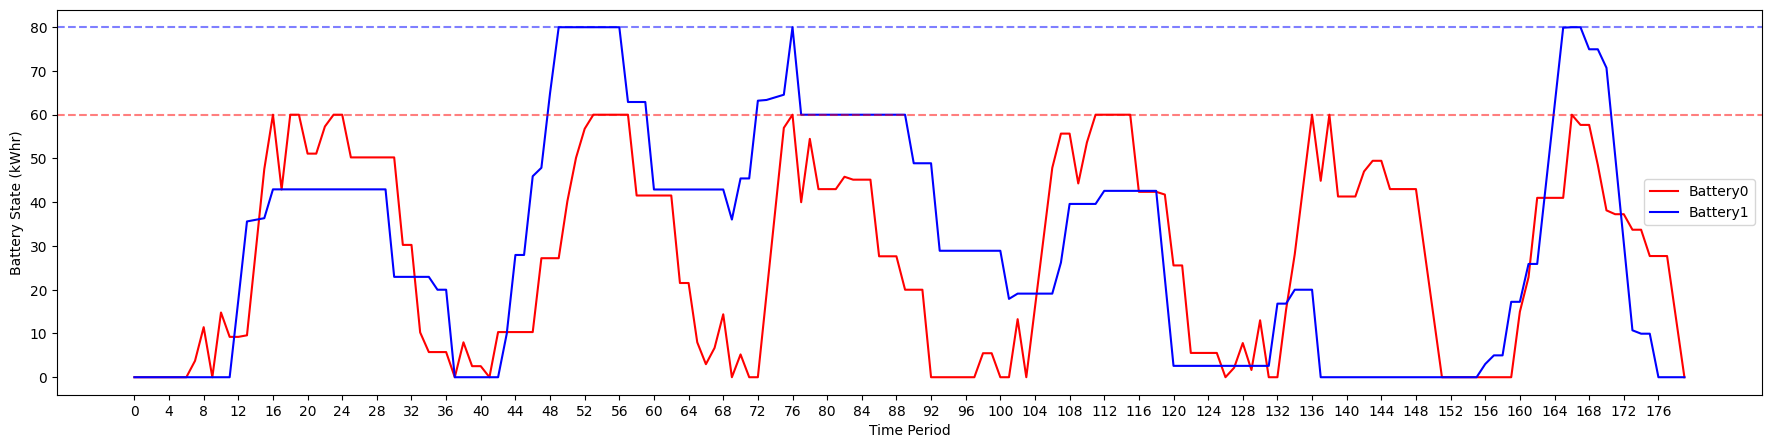

In [40]:
plt.figure(figsize=(22,5))
s0, = plt.plot(sol_level['Battery0'], c = 'red')
s1, = plt.plot(sol_level['Battery1'], c = 'blue')
plt.ylabel('Battery State (kWhr)')
plt.xlabel('Time Period')
plt.xticks(range(0,len(solar_values),4))
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='red', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level['Battery1']==capacity['Battery1'])}");

*Note: With the default capacity settings, the bigger battery (Battery1) reaches its maximum capacity only twice, whereas Battery0 frequently hits its capacity limit. How might altering these capacity values impact the optimization process and results?*

Our last set of decision variables is the amount of electricity to buy from the grid, in which the total was minimized in the objective, and plot that over time. 

Proportion of time periods where electrity is purchaced from the grid: 0.45


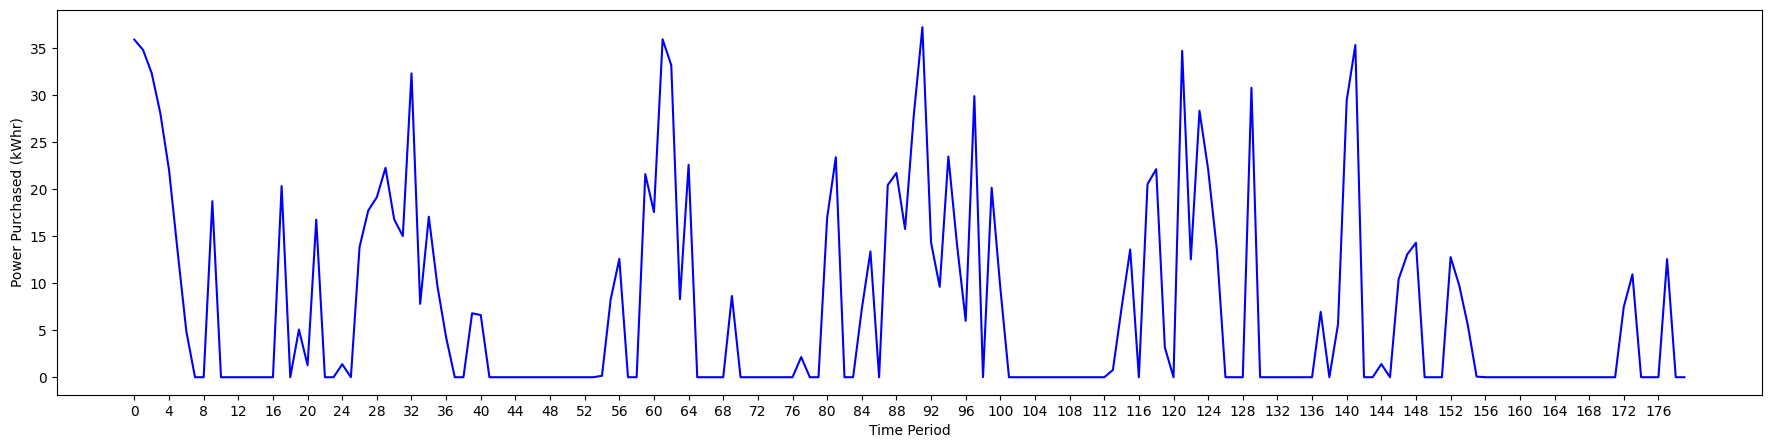

In [41]:
sol_grid = pd.Series(m.getAttr('X',grid))
plt.figure(figsize=(22,5))
plt.xticks(range(0,len(solar_values),4))
plt.plot(sol_grid, c = 'blue');
plt.ylabel('Power Purchased (kWhr)')
plt.xlabel('Time Period')
# Print the proportion of time periods where electricity is purchased from the grid
print(f"Proportion of time periods where electrity is purchaced from the grid: {round(sum(sol_grid > 0)/len(sol_grid),3)}")

*Note: Above, the number of periods where electricity was purchased from the grid was calculated. Is this the same as minimizing the total amount purchased? If not (hint, it's not!), how would you model that? (Another hint, that would require additional binary variables)*

#### 4.3. Changing the Objective Function (Sensitive Analysis)
As mentioned at the beginning of the example, we'll consider two objective functions with the second minimizing the cost of electricity purchaced. To do that, we need anticipated prices for each time period. 

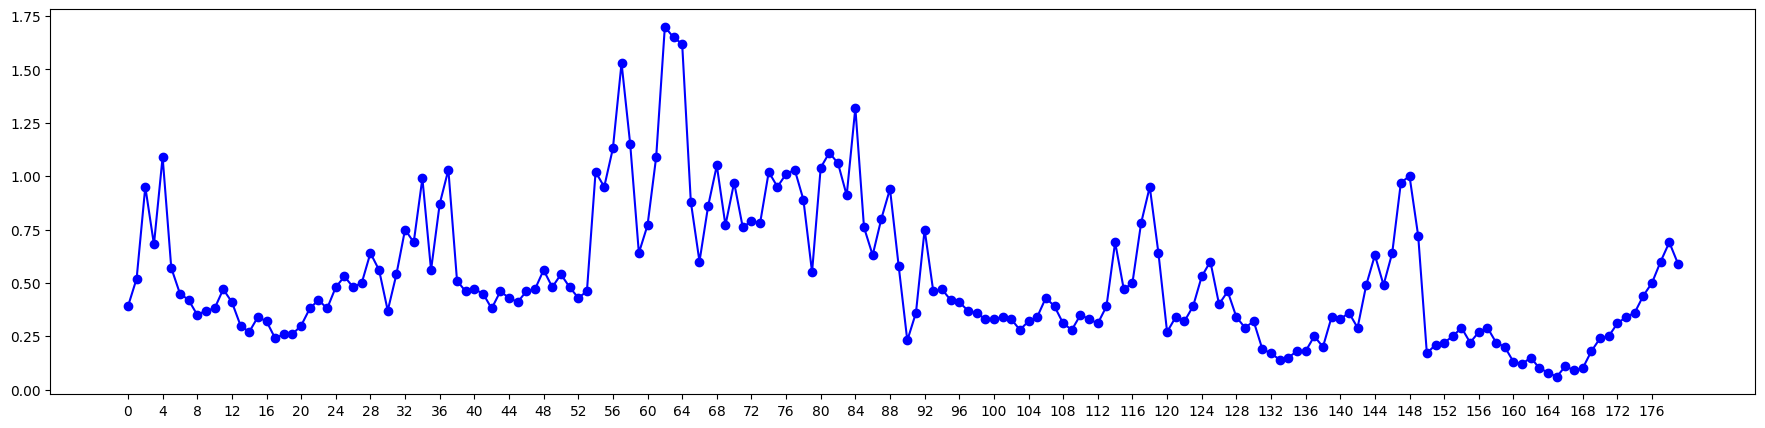

In [42]:
avg_price = pd.read_csv('ml_expected_price.csv')
plt.figure(figsize=(22,5))
plt.xticks(range(0,len(avg_price),4))
plt.plot(avg_price.index, avg_price.price, '-o', c = 'blue');

To change the objective, it just needs to be set again. The rest of the model stays the same so no further adjustments are needed. 

In [43]:
m.setObjective(gp.quicksum(avg_price.price[time]*grid[time] for time in time_periods), GRB.MINIMIZE)

In [44]:
m.optimize(); # run the optimization again
print(f"Energy cost for the week: ${round(m.objVal,2)}")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x294dd157
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]

MIP start from previous solve produced solution with objective 614.789 (0.01s)
MIP start from previous solve produced solution with objective 614.789 (0.01s)
Loaded MIP start from previous solve with objective 614.789

Presolve removed 84 rows and 265 columns
Presolve time: 0.00s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 6.062424e+02, 682 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    C

We can extract the decision variables as before to see how the solution changes given the new objective.

The total energy purchased from the grid:

In [45]:
sol_grid = pd.Series(m.getAttr('X',grid))
print("The total energy purchased from the grid is", round(sol_grid.sum(),3), "kWhr")

The total energy purchased from the grid is 1328.194 kWhr


 We can plot the battery levels over time to see how they change throughout the day. 

Periods at Battery0 at Full Capacity: 28
Periods at Battery1 at Full Capacity: 23


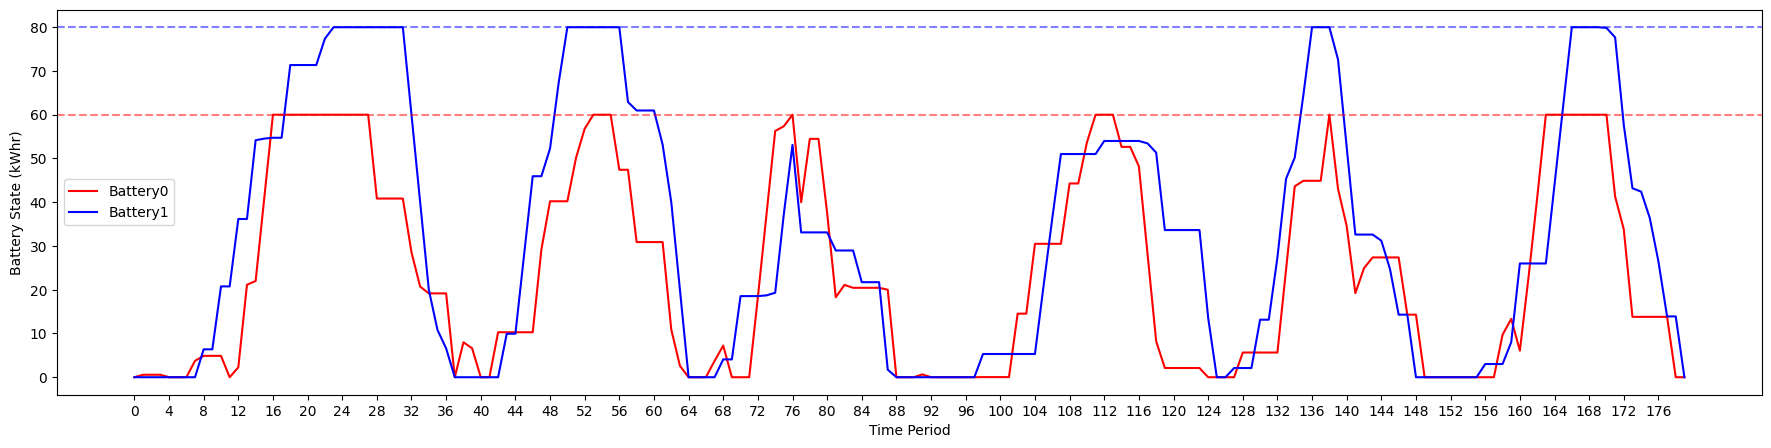

In [46]:
sol_level_cost = pd.Series(m.getAttr('X',state))
plt.figure(figsize=(22,5))
plt.plot(sol_level_cost['Battery0'], c ='red')
plt.plot(sol_level_cost['Battery1'], c ='blue')
plt.ylabel('Battery State (kWhr)')
plt.xlabel('Time Period')
plt.xticks(range(0,len(solar_values),4))
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='red', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level_cost['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level_cost['Battery1']==capacity['Battery1'])}");

We see that each battery spends more time full or near-full, particuarly Battery0. This shows how adding cost will make batteries hold on to electricity to then be discharged during time periods where the cost is highest. 

Here are some follow-on questions to take a deeper dive into this problem:
- How much electricity was purchased from the grid after changing the objective?
- Given the prices used for the seconds objective, what would the cost have been for the first solution that minimized electricity purchased?
- How would increasing the capacity of Battery0 in the second objective change the solution?

### 6. 💡 Reflexion: Enhancing Sensitivity Analysis in Energy⚡ Optimization with Generative AI  🤖  

Generative AI can significantly enhance sensitivity analysis in energy storage optimization by automating and accelerating the exploration of different scenarios. 🚀 Here's how AI can assist in answering the follow-on questions:  

#### 1️⃣ Electricity Purchased from the Grid 🔌  
- 📊 AI can generate multiple simulations by modifying the optimization objective and automatically track the changes in grid electricity purchases.  
- 📉 By leveraging large datasets, AI models can predict how different pricing strategies impact the reliance on grid electricity over time.  

#### 2️⃣ Cost Comparison of Different Objectives 💰  
- 🔄 Instead of manually recalculating the cost of the first solution under the new pricing scheme, Generative AI can automatically re-evaluate historical solutions under different price structures.  
- 📈 AI-driven scenario analysis can uncover hidden cost trade-offs and provide insights into how price variations affect overall system performance.  

#### 3️⃣ Impact of Increasing Battery Capacity 🔋  
- 🧪 Generative AI can conduct rapid "what-if" experiments, adjusting Battery0’s capacity dynamically and observing the effects on electricity storage and discharge patterns.  
- 🎯 It can predict optimal battery sizes to maximize cost savings while ensuring reliable energy availability.  

By replacing manual sensitivity analysis with AI-driven automation, decision-makers can efficiently explore different strategies, optimize energy storage, and reduce costs—all with minimal human intervention. 🤖💡  
 


### 6. Conclusion

This example walked through an instance of how to model an energy system that leverages a time series forecast of solar availability. Part of the challenge in modeling such systems is how decisions from one time periods impact the next. We also looked at two ways to define a decision variables bounds and saw that updating an objective function is very straightforward, possibly having a big impact on the solution. There are more [energy related](https://www.gurobi.com/resource/electrical-power-generation-jupyter-notebook-i-and-ii/) examples in Gurobi's extensive set of [notebook examples](https://www.gurobi.com/resource/modeling-examples-using-the-gurobi-python-api-in-jupyter-notebook/).
